![Banner](./img/AI_Special_Program_Banner.jpg)

# Exercises on evaluation and quality measures
---

In this exercise, you have to correctly evaluate your models from the last exercise (Classification). You should first check whether your models tend to over/underfit. Furthermore, you should find suitable hyperparameter configurations and provide an unbiased estimate of the generalization ability of your models for your pipeline.

## Data preparation
---

To compare the actual performance of our models from Classification, we use the same data ([Heart Disease Data Set](https://archive.ics.uci.edu/ml/datasets/heart+disease)).

In [1]:
%matplotlib inline

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [55]:
df = pd.read_csv('./data/heart_desease.csv')

In [4]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,male,typical angina,145.0,233.0,True,ventricual hypertrophy,150.0,yes,2.3,downsloping,0,fixed defect,0
1,67.0,male,asymptomatic,160.0,286.0,False,ventricual hypertrophy,108.0,no,1.5,flat,3,normal,2
2,67.0,male,asymptomatic,120.0,229.0,False,ventricual hypertrophy,129.0,no,2.6,flat,2,reversable defect,1
3,37.0,male,non-anginal pain,130.0,250.0,False,normal,187.0,yes,3.5,downsloping,0,normal,0
4,41.0,female,atypical angina,130.0,204.0,False,ventricual hypertrophy,172.0,yes,1.4,upsloping,0,normal,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    object 
 2   cp        303 non-null    object 
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    bool   
 6   restecg   303 non-null    object 
 7   thalach   303 non-null    float64
 8   exang     303 non-null    object 
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    object 
 11  ca        303 non-null    object 
 12  thal      303 non-null    object 
 13  num       303 non-null    int64  
dtypes: bool(1), float64(5), int64(1), object(7)
memory usage: 31.2+ KB


Extraction of attributes and classes as `X` and `y`:

In [56]:
df['num'] = df['num'].apply(lambda x: 0 if x == 0 else 1)
y = df['num']
X = df.drop('num', axis=1)

Division of the data into training and test data. The test data is used for the final evaluation of the final model:

In [57]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, 
                     test_size=0.1,
                     stratify = y,
                     random_state=1)

<h1 style="color:blue">Exercises</h1>

---

<h2 style="color:blue">Task 1 - Decision tree</h2>

<h3 style="color:blue">Task 1.1 - Pipeline</h3>

Create a pipeline that contains a decision tree as a prediction model, as well as the necessary steps for data preparation (*transformers*). Use one-hot encoding for the categorical attributes of the data set.

**Notes:**
* The [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) can be used to transform the data in the pipeline (see explanations [here](https://scikit-learn.org/stable/modules/compose.html#columntransformer-for-heterogeneous-data)).
* You can automatically select the categorical variables from the DataFrame with [`make_column_selector`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_selector.html)
* Use `handle_unknown = 'ignore'` for the OneHotEncoder to avoid error messages regarding categories that only occur in one split.

In [71]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_selector

ct = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'),
    make_column_selector(dtype_include=[object, bool])),
    remainder='passthrough')

In [72]:
# Your solution
#from sklearn.preprocessing import StandardScaler
#from sklearn.decomposition import PCA
from sklearn import tree
from sklearn.pipeline import make_pipeline

pipe_dt = make_pipeline(ct,
                        tree.DecisionTreeClassifier(random_state=1))

pipe_dt.fit(X_train, y_train)
y_pred = pipe_dt.predict(X_test)
print('Accuracy: %.3f' % pipe_dt.score(X_test, y_test))

Accuracy: 0.645


<h3 style="color:blue">Task 1.2 - Over/Underfitting? Validation curve!</h3>

Decision trees tend to overfit very quickly. Check for different values of `max_depth` whether overfitting is present. Use a **validation curve** for this purpose.

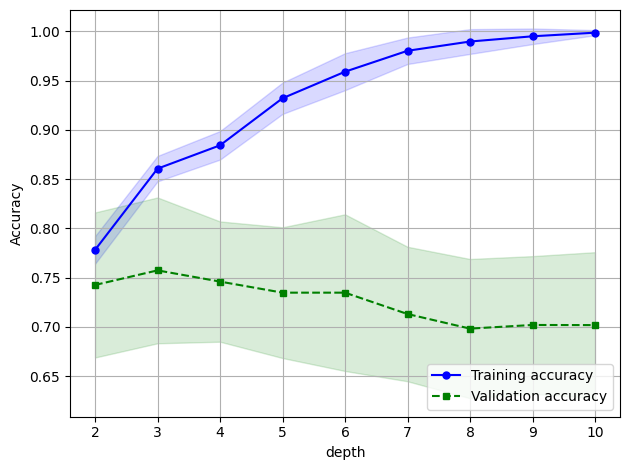

In [73]:
from sklearn.model_selection import validation_curve

param_range = [2,3,4,5,6,7,8,9,10]
train_scores, test_scores = validation_curve(
                estimator=pipe_dt, 
                X=X_train, 
                y=y_train, 
                param_name='decisiontreeclassifier__max_depth', 
                param_range=param_range,
                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='Training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='Validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.legend(loc='lower right')
plt.xlabel('depth')
plt.ylabel('Accuracy')
plt.tight_layout()
# plt.savefig('images/06_06.png', dpi=300)
plt.show()

<h3 style="color:blue">Task 1.3 - Hyperparameter Optimization with GridSearch</h3>

Use `GridSearchCV` to find suitable values for `max_depth` and `min_samples_leaf` to obtain a decision tree with the highest possible validation accuracy. Then determine the **accuracy on the test data** for the **best model**. Compare your result with an unbiased estimator of generalization ability by **nested cross-validation**.

In [74]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'decisiontreeclassifier__max_depth' : np.arange(2,6),
              'decisiontreeclassifier__min_samples_leaf' : [2,6,10,12,14,16]}]

gs = GridSearchCV(estimator=pipe_dt, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  refit=True,
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.7936507936507937
{'decisiontreeclassifier__max_depth': 4, 'decisiontreeclassifier__min_samples_leaf': 12}


<h3 style="color:blue">Task 1.4 - Optimization with regard to sensitivity</h3>

The use case of our data is the detection of a disease. Therefore, the sensitivity of a model is particularly important. Find a model configuration with the highest sensitivity using `GridSearchCV`. Does the model differ from the model in task 1.3?

In [ ]:
# Your solution

<h2 style="color:blue">Task 2 - Logistic regression</h2>

The tasks for the logistic regression are largely analogous to the decision tree.

<h3 style="color:blue">Task 2.1 - Pipeline</h3>

Create a pipeline that contains a logistic regression as a prediction model, as well as the necessary steps for data preparation (*transformers*). Use one-hot encoding for the categorical attributes of the data set. Additionally scale the numerical attributes.

**Notes:**
* The [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) can be used to transform the data in the pipeline (see explanations [here](https://scikit-learn.org/stable/modules/compose.html#columntransformer-for-heterogeneous-data)).
* You can automatically select the categorical variables from the DataFrame with [`make_column_selector`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_selector.html)
* Use `handle_unknown = 'ignore'` for the OneHotEncoder to avoid error messages regarding categories that only occur in one split.

In [63]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(ct,
                        StandardScaler(),
                        #PCA(n_components=2),
                        LogisticRegression(random_state=1, solver='lbfgs'))
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print('Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

Accuracy: 0.806


<h3 style="color:blue">Task 2.2 - Over/Underfitting? Validation curve!</h3>

Visualize a possible bias-variance problem using the validation curve for different values of $C$.

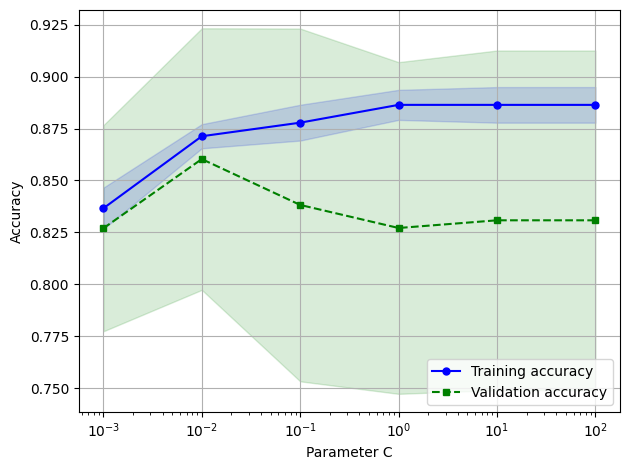

In [64]:
# Your Solution
from sklearn.model_selection import validation_curve


param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
                estimator=pipe_lr, 
                X=X_train, 
                y=y_train, 
                param_name='logisticregression__C', 
                param_range=param_range,
                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='Training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='Validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
#plt.ylim([0.8, 1.0])
plt.tight_layout()
# plt.savefig('images/06_06.png', dpi=300)
plt.show()

<h3 style="color:blue">Task 2.3 - Hyperparameter Optimization with GridSearch</h3>

Use `GridSearchCV` to find suitable values for `solver` and `C` and `penalty`. Then determine the **accuracy on the test data** for the **best model**. Compare your result with an unbiased estimation of the generalization ability by **nested cross-validation**.

**Notes:**
* Suitable combinations for `solver` and `penalty` can be found [here](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)
* To avoid invalid combinations, you can use a list of several dictionaries as a parameter grid

In [70]:
# Your solution
from sklearn.model_selection import GridSearchCV

pipe_lr = make_pipeline(ct,
                        StandardScaler(),
                         LogisticRegression(random_state=1, solver='liblinear'))


param_grid = [{'logisticregression__C' : np.logspace(-3,3,7),
              'logisticregression__penalty' : ['l1', 'l2'],
              'logisticregression__solver' : ['liblinear', 'saga']}]

gs = GridSearchCV(estimator=pipe_lr, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  refit=True,
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.8641534391534392
{'logisticregression__C': 0.1, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}


<h3 style="color:blue">Task 2.4 - Optimization with regard to sensitivity</h3>

Use `GridSearchCV` to find a model configuration with the greatest sensitivity. Does the model differ from the model in task 2.3?

In [ ]:
# Your solution